In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import core.bot as bot
import ast
from core.filters import macd, ema


In [2]:
CSV_PATH = "data/BTC-Daily.csv"      # e.g. 'data/BTC-Daily.csv'
DATE_COL = "date"                    # 'date' in some files
CLOSE_COL = "close"                  # 'close' in some files
TRAIN_TO = "2019-12-31"

# --- Load & split ---
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
mask_train  = df[DATE_COL] <= TRAIN_TO
dates_test  = df.loc[~mask_train, DATE_COL].to_numpy()
prices_test = df.loc[~mask_train, CLOSE_COL].to_numpy()



In [8]:
df = pd.read_csv("results/results_pop50_g100_20250501_141358.csv")
df["test_obj"] = df["test"].astype(float)
df["train_obj"] = df["train"].astype(float)

# For each algorithm, find the row with the minimum test objective (i.e. best profit)
idx_best = df.groupby("alg")["test_obj"].idxmin()
best_df = df.loc[idx_best].reset_index(drop=True)

# Parse the theta strings into Python lists
best_df["theta_parsed"] = best_df["theta"].apply(ast.literal_eval)

# Display the best parameters for each algorithm
best_df[["alg", "seed", "train_obj", "test_obj", "theta_parsed","pop_size","gens","stalled_gens","tolerance","patience","fitness_history","time(seconds)"]]

,alg,seed,train_obj,test_obj,theta_parsed,pop_size,gens,stalled_gens,tolerance,patience,fitness_history,time(seconds)
0,ABC,962,-56382.460376,-8715.674840,"[5.828558506265031, 2.2682425324336823, 0.05, ...",50,16,10,0.0001,10,"[-9830.26934796036, -10404.51244092203, -23558...",4.10
1,CAB,487,-45484.988367,-8055.295297,"[5.749148813300664, 1.6058270858766917, 0.0609...",50,19,10,0.0001,10,"[-36171.9130845364, -36251.34454601532, -36251...",1.58
2,GWO,68,-50141.231316,-8684.058276,"[5.520001809500798, 0.26336871939634027, 0.230...",50,22,10,0.0001,10,"[-9057.148207660506, -18769.765002810534, -187...",1.40


In [9]:
theta_dict = best_df.set_index("alg")["theta_parsed"].to_dict()

In [10]:
def plot_crossovers(best_df, prices_test, dates_test):
    """
    Plot close price, buy/sell signals, and indicator lines (fast/slow signals)
    for each best configuration (one subplot per run).
    
    Args:
        best_df: DataFrame with columns ['theta_parsed', 'alg', 'seed']
        prices_test: np.array of test close prices
        dates_test: np.array of corresponding dates
    """
    n = len(best_df)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

    if n == 1:
        axes = [axes]  # ensure axes is iterable even for n=1

    for ax, (_, row) in zip(axes, best_df.iterrows()):
        theta = row["theta_parsed"]
        d1, t1, a1, d2, t2, a2, buy_delay, sell_delay= theta

        # Get crossover signals
        buy_idx, sell_idx, tail_len = bot.crossover_signals(prices_test, theta)
        dates_tail  = dates_test[-tail_len:] 
        prices_tail = prices_test[-tail_len:]

        # Build the fast and slow moving average signals
        fast_signal = bot.make_signal(prices_test, int(d1), int(t1), a1)[-tail_len:]
        slow_signal = bot.make_signal(prices_test, int(d2), int(t2), a2)[-tail_len:]
        
        # Ensure no out-of-bounds indices
        buy_idx = buy_idx[(buy_idx >= 0) & (buy_idx < len(prices_tail))]
        sell_idx = sell_idx[(sell_idx >= 0) & (sell_idx < len(prices_tail))]

        # --- Plot
        ax.plot(dates_tail, prices_tail, label="Close Price", color="black", linewidth=1)
        ax.plot(dates_tail, slow_signal, label=f"Slow MA (d={int(d2)}) {bot.TYPE_MAP.get(int(t2))}", color="orange", linestyle="-")
        ax.plot(dates_tail, fast_signal, label=f"Fast MA (d={int(d1)}) {bot.TYPE_MAP.get(int(t1))}", color="teal", linestyle="--")

        ax.scatter(dates_tail[buy_idx],  prices_tail[buy_idx],
                   marker="^", color="green", s=80, label="Buy Signal")
        ax.scatter(dates_tail[sell_idx], prices_tail[sell_idx],
                   marker="v", color="red",   s=80, label="Sell Signal")

        ax.set_title(f"{row['alg']} Crossover (Seed {row['seed']} | Starting + Profit: ${-1 * row["test_obj"]:.2f})", fontsize=12)
        ax.legend(loc="upper left")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

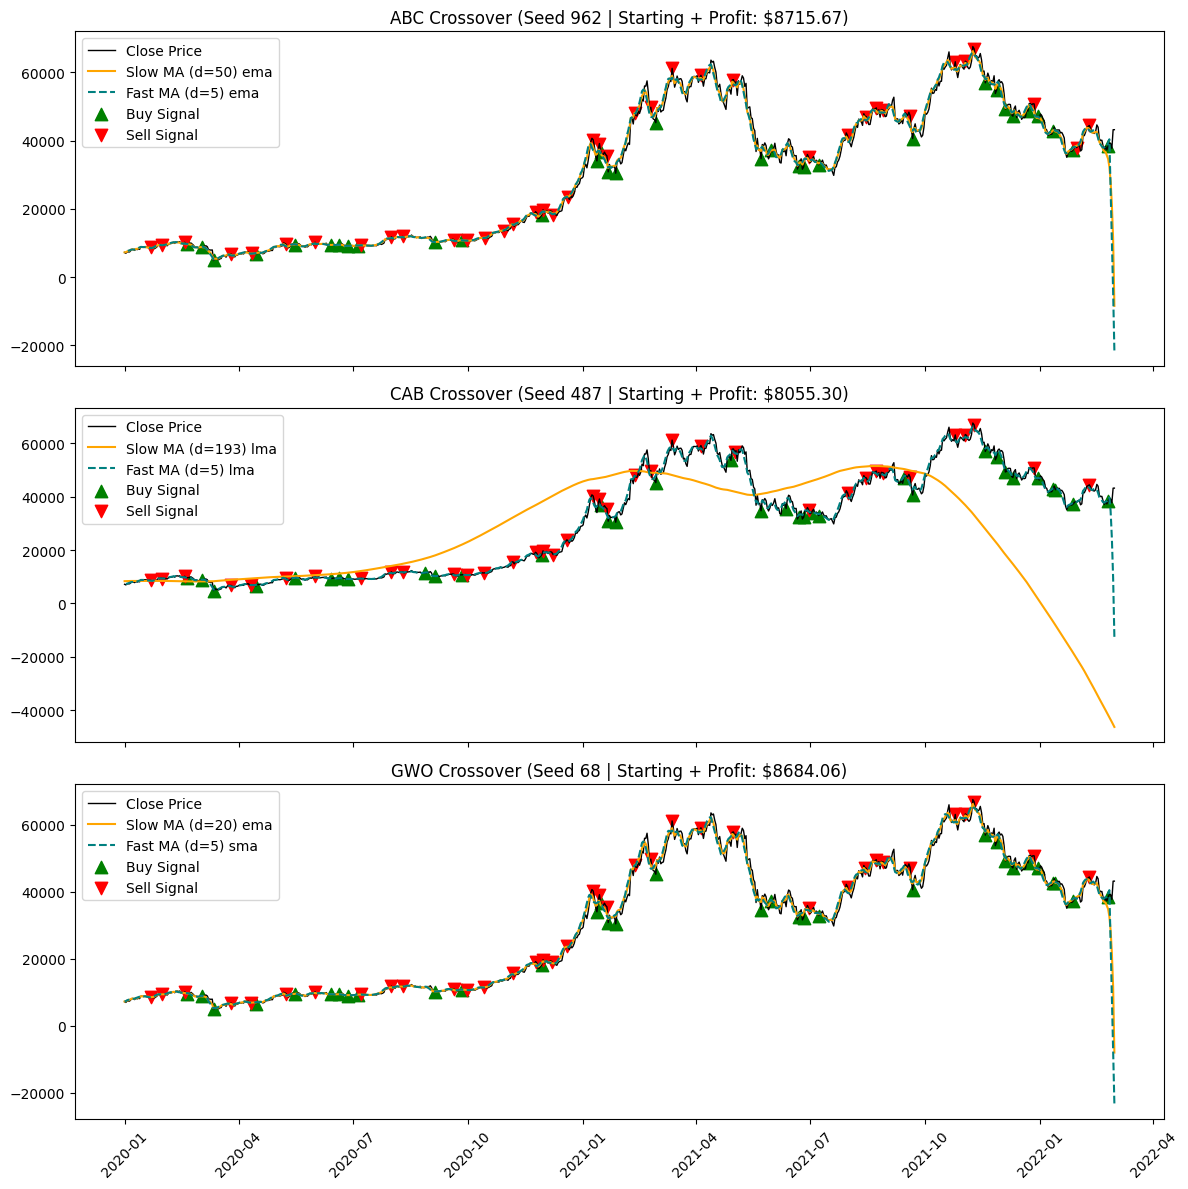

In [11]:
plot_crossovers(best_df, prices_test, dates_test)

In [12]:
def plot_macd_custom(prices, macd_window=26, alpha=0.2, signal_window=9, title="MACD Visualisation"):
    """
    Plot MACD (your implementation), signal line (EMA of MACD), histogram,
    and mark crossover buy/sell signals.
    """
    # MACD and Signal
    macd_line = macd(prices, macd_window, alpha)
    signal_line = ema(macd_line, signal_window, alpha)

    # Align length
    min_len = min(len(macd_line), len(signal_line))
    macd_line = macd_line[-min_len:]
    signal_line = signal_line[-min_len:]
    hist = macd_line - signal_line
    price_tail = prices[-min_len:]

    # Detect crossovers
    cross = np.sign(macd_line - signal_line)
    cross_diff = np.diff(cross, prepend=cross[0])
    print(np.where(cross_diff > 0)[0])
    buy_idx = np.where(cross_diff > 0)[0] -4
    sell_idx = np.where(cross_diff < 0)[0] -4

    # --- Plot
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

    # Top plot: price with crossover markers
    ax[0].plot(price_tail, label="Close Price", color="black", linewidth=1)
    ax[0].scatter(buy_idx, price_tail[buy_idx], marker="^", color="green", s=80, label="Buy Signal")
    ax[0].scatter(sell_idx, price_tail[sell_idx], marker="v", color="red", s=80, label="Sell Signal")
    ax[0].set_title(title)
    ax[0].legend()
    ax[0].grid(True)

    # Bottom plot: MACD + Signal + Histogram
    ax[1].plot(macd_line, label="MACD", color="blue")
    ax[1].plot(signal_line, label="Signal", color="orange")
    ax[1].bar(np.arange(len(hist)), hist, label="Histogram",
              color=np.where(hist > 0, "green", "red"), alpha=0.4)

    ax[1].axhline(0, color="gray", linestyle="--", linewidth=0.5)
    ax[1].set_xlabel("Time Index")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


[ 31  66  85 101 127]


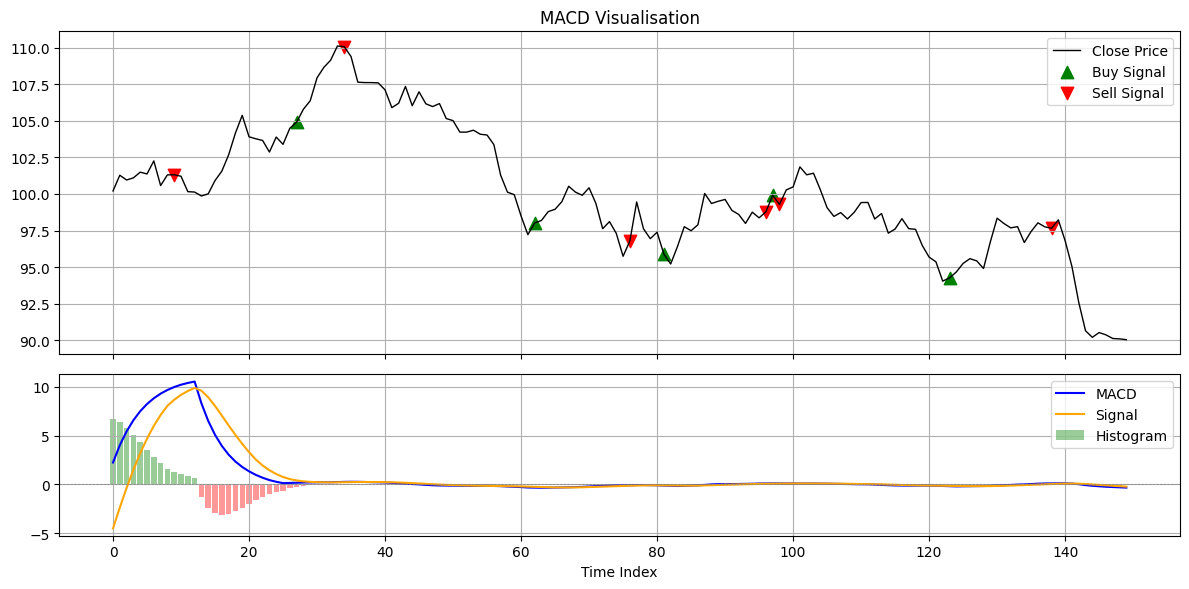

In [13]:
prices = np.cumsum(np.random.normal(0, 1, size=150)) + 100

plot_macd_custom(prices, macd_window=26, alpha=0.2, signal_window=9)

In [14]:
def compare_shifted_signals(prices, macd_window=26, alpha=0.2, signal_window=9, shift_vals=[0, 2, 4]):
    """
    Plot and compare multiple versions of buy/sell signals from MACD crossover
    with different entry delays (shifted forward in time), annotate index,
    and compute cumulative profit/loss for each shift, color-coded by shift.
    """
    macd_line = macd(prices, macd_window, alpha)
    signal_line = ema(macd_line, signal_window, alpha)

    min_len = min(len(macd_line), len(signal_line))
    prices = prices[-min_len:]
    macd_line = macd_line[-min_len:]
    signal_line = signal_line[-min_len:]
    cross = np.sign(macd_line - signal_line)
    cross_diff = np.diff(cross, prepend=cross[0])

    # Assign distinct colors for each shift
    color_palette = plt.cm.viridis(np.linspace(0.2, 0.9, len(shift_vals)))

    plt.figure(figsize=(14, 6))
    plt.plot(prices, label="Price", color="black", linewidth=1)

    profit_legend = []

    for i, shift in enumerate(shift_vals):
        color = color_palette[i]

        buy_idx  = np.where(cross_diff > 0)[0] - shift
        sell_idx = np.where(cross_diff < 0)[0] + shift

        buy_idx = buy_idx[(buy_idx >= 0) & (buy_idx < len(prices))]
        sell_idx = sell_idx[(sell_idx >= 0) & (sell_idx < len(prices))]

        trades = []
        b = s = 0
        while b < len(buy_idx) and s < len(sell_idx):
            if buy_idx[b] < sell_idx[s]:
                trades.append((buy_idx[b], sell_idx[s]))
                b += 1
                s += 1
            else:
                s += 1

        profits = [prices[s] - prices[b] for b, s in trades]
        total_profit = sum(profits)

        # Plot and annotate
        for b, s in trades:
            plt.scatter(b, prices[b], marker="^", color=color, s=80, alpha=0.8, label=f"Buy (shift={shift})" if b == trades[0][0] else "")
            plt.annotate(str(b), (b, prices[b]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color=color)

            plt.scatter(s, prices[s], marker="v", color=color, s=80, alpha=0.8, label=f"Sell (shift={shift})" if s == trades[0][1] else "")
            plt.annotate(str(s), (s, prices[s]), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=8, color=color)

        profit_legend.append(f"Shift={shift} | PnL: {total_profit:.2f}")

    plt.title("MACD Crossover Comparison with Shifted Signal Timing")
    plt.xlabel("Time Index")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend(profit_legend, loc="upper left")
    plt.tight_layout()
    plt.show()


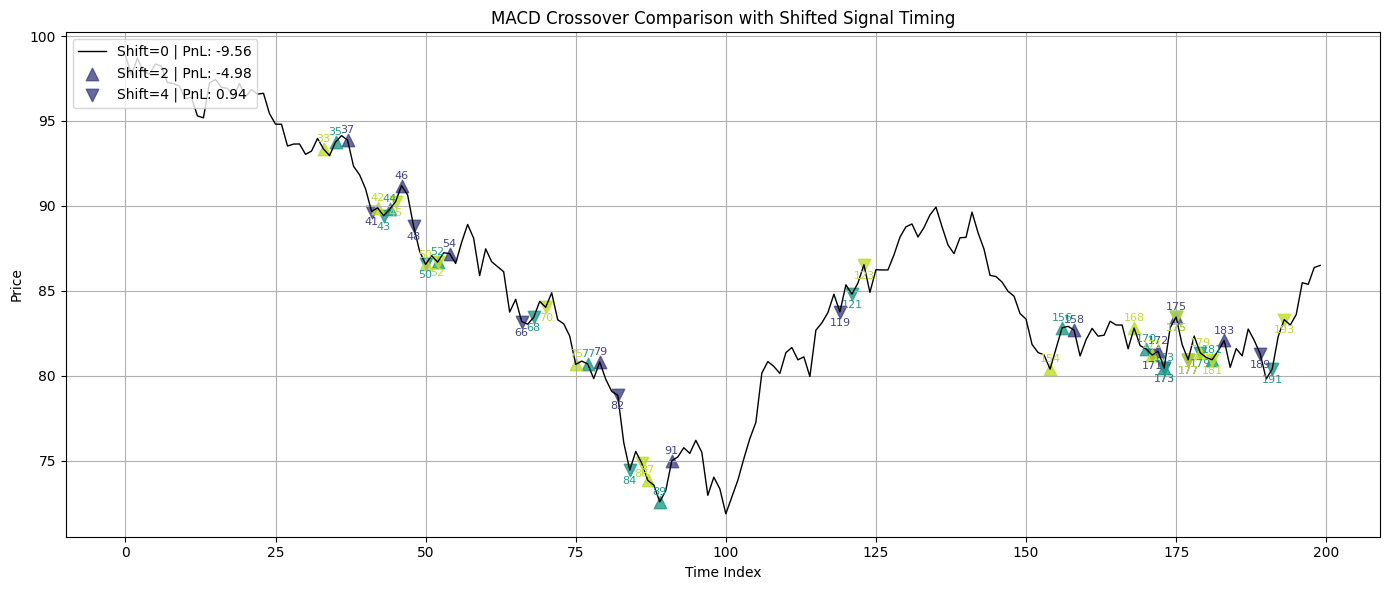

In [25]:
# Example price series
prices = np.cumsum(np.random.normal(0, 1, size=200)) + 100

compare_shifted_signals(prices, shift_vals=[0, 2, 4])